## Analyse des bases de données 


In [254]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [255]:
df_corkstation = pd.read_csv('df1.csv')
df_vst = pd.read_csv('df2.csv')
print(df_corkstation.columns)
df1=df_corkstation
df2=df_vst


Index(['date', 'ind', 'rain', 'ind.1', 'temp', 'ind.2', 'wetb', 'dewpt',
       'vappr', 'rhum', 'msl', 'ind.3', 'wdsp', 'ind.4', 'wddir', 'ww', 'w',
       'sun', 'vis', 'clht', 'clamt'],
      dtype='object')


### Valeurs abérantes de quelques paramètres 

<Axes: ylabel='clht'>

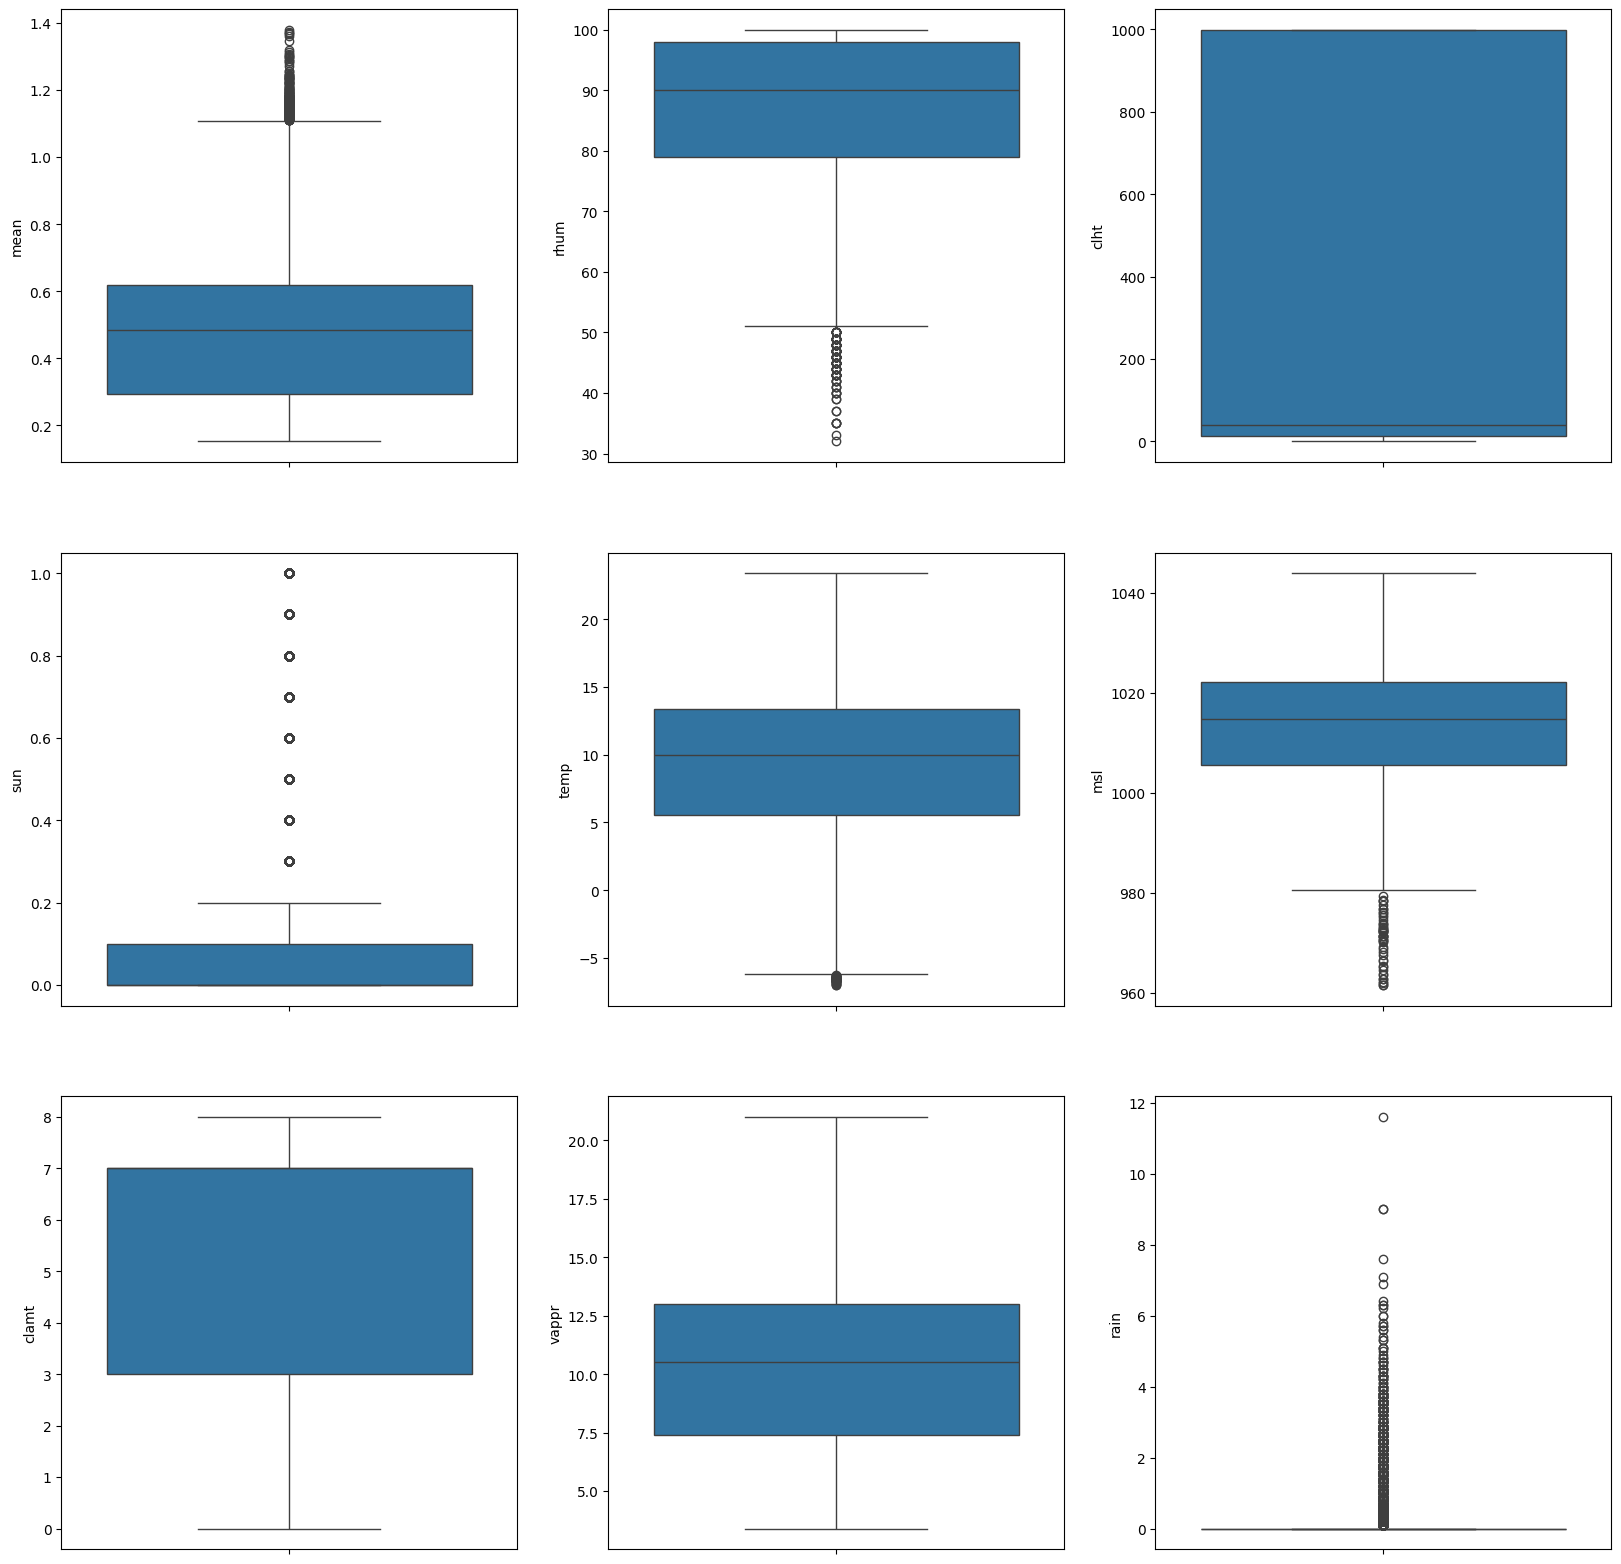

In [60]:
f, axes = plt.subplots(3, 3, figsize=(20,20))
sns.boxplot(df2['mean'],ax=axes[0,0])
sns.boxplot(df2['temp'],ax=axes[1,1])
sns.boxplot(df1['rain'],ax=axes[2,2])
sns.boxplot(df1['sun'],ax=axes[1,0])
sns.boxplot(df1['rhum'],ax=axes[0,1])
sns.boxplot(df1['vappr'],ax=axes[2,1])
sns.boxplot(df1['msl'],ax=axes[1,2])
sns.boxplot(df1['clamt'],ax=axes[2,0])
sns.boxplot(df1['clht'],ax=axes[0,2])



## Interpolation des données manquantes et Rassemblement des deux datasets


In [256]:
# Changing index to date column
df_corkstation['date'] = pd.to_datetime(df_corkstation['date'])
df_corkstation.set_index('date', inplace=True)

# Interpolating over missing data
df_corkstation = df_corkstation.replace({' ': '-1'}, regex=True)
df_corkstation['wetb'] = pd.to_numeric(df_corkstation['wetb'])
df_corkstation['vis'] = pd.to_numeric(df_corkstation['vis'])
df_corkstation = df_corkstation.replace({-1: np.nan}, regex=True)
df_corkstation = df_corkstation.interpolate()



# Resample for each 30 min and interpolating
df_corkstation_resampled = df_corkstation.resample('30T').interpolate(method='linear')



# Lists to be used
weekend_list = []
season_list = []
work_time_list = []

# Get season function
def get_season(date):
    year = date.year
    seasons = {
        'spring': (pd.Timestamp(year=year, month=3, day=21), pd.Timestamp(year=year, month=6, day=20)),
        'summer': (pd.Timestamp(year=year, month=6, day=20), pd.Timestamp(year=year, month=9, day=20)),
        'fall': (pd.Timestamp(year=year, month=9, day=21), pd.Timestamp(year=year, month=12, day=20)),
        'winter': (pd.Timestamp(year=year, month=12, day=21), pd.Timestamp(year=year + 1, month=3, day=19))
    }
    
    if seasons['spring'][0] <= date <= seasons['spring'][1]:
        return 1
    elif seasons['summer'][0] <= date <= seasons['summer'][1]:
        return 2
    elif seasons['fall'][0] <= date <= seasons['fall'][1]:
        return 3
    else:
        return 4
    
# Adding info to lists
for date in df_corkstation_resampled.index.tolist():
    if date.weekday() == 5 or date.weekday() == 6:
        weekend_list.append(1)
    else:
        weekend_list.append(0)

    season_list.append(get_season(date))

    if date.hour >= 8 and date.hour <= 18:
        work_time_list.append(1)
    else:
        work_time_list.append(0)

# Creating dataframes with info
weekend_df = pd.DataFrame({'weekend': weekend_list})
season_df = pd.DataFrame({'season': season_list})
work_time_df = pd.DataFrame({'work_time': work_time_list})

# Concating created info to the dataframe corkstation
time_info = pd.concat([weekend_df, season_df, work_time_df], axis=1)
time_info.set_index(df_corkstation_resampled.index, inplace=True)
df_corkstation_resampled = pd.concat([df_corkstation_resampled, time_info], axis=1)



date_to_be_cropped = datetime.datetime(2010,12 ,31 , 23, 30)
df_corkstation_cropped = df_corkstation_resampled[df_corkstation_resampled.index <= date_to_be_cropped]

df_vst['time'] = pd.to_datetime(df_vst['time'])
df_vst.set_index('time', inplace=True)
df_vst_cropped = df_vst[df_vst.index<=date_to_be_cropped]



df_corkstation_cropped = df_corkstation_cropped.drop(columns=['temp'])
df_to_train_and_test = pd.concat([df_corkstation_cropped, df_vst_cropped], axis=1)






## Visualisation et calcul des différentes corrélation avec la consommation électrique sur toutes les données fournies 

In [ ]:
columns = df_to_train_and_test.columns 
for name in columns : 
    try : 
        sns.pairplot(df_to_train_and_test,x_vars=[name], y_vars='mean', height=4, aspect=3, kind='scatter')
    except: 
        print(name)


### Remarque: 
Nous remarquons que l'humidité 'rhum', la hauteur des nuages 'clht' , la vapeur d'eau 'vappr' , la température 'temp' et la pluie 'rain' ont une corrélation importante avec la consommation électrique. Cependant on va calculer ces corrélations. 

### Indices de corrélation


In [285]:
date_limit = pd.Timestamp("2010-12-14 00:23:30")
df = df_to_train_and_test[:date_limit]
df['wetb'] = df['wetb'].astype(float)
df['ind.2'] = df['ind.2'].astype(float)
df['ind.3'] = df['ind.3'].astype(float)
df['ind.4'] = df['ind.4'].astype(float)
df['vis'] = df['vis'].astype(float)
df['dewpt'] = df['dewpt'].astype(float)
df = df.drop(columns={"ind.3","ind.4"})
columns = df.columns
covariance_matrix = df.corr() 
covariance_result = covariance_matrix['mean']
noms = covariance_result.keys
values = covariance_result.values
values = [abs(value) for value in values] 

d = {('consommation',columns[i]) : values[i] for i in range(len(values)) if columns[i] != 'mean'}
d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse =True)}
print(d)



{('consommation', 'work_time'): 0.3359401515325331, ('consommation', 'season'): 0.24996243336799642, ('consommation', 'dewpt'): 0.22171277147684137, ('consommation', 'vappr'): 0.21439399705275974, ('consommation', 'wetb'): 0.19278824150706322, ('consommation', 'temp'): 0.15710934658111295, ('consommation', 'rhum'): 0.15632670615763866, ('consommation', 'ind'): 0.1348232704145621, ('consommation', 'vis'): 0.11141599801336285, ('consommation', 'wdsp'): 0.09499715356818984, ('consommation', 'msl'): 0.08554884955686794, ('consommation', 'ind.2'): 0.06541204308538948, ('consommation', 'wddir'): 0.05878683099628914, ('consommation', 'ind.1'): 0.058674170294889874, ('consommation', 'sun'): 0.05809976261185752, ('consommation', 'clht'): 0.033772097513598824, ('consommation', 'clamt'): 0.030934237169861923, ('consommation', 'rain'): 0.014736488017655982, ('consommation', 'w'): 0.012656427740590562, ('consommation', 'weekend'): 0.005299363014912079, ('consommation', 'ww'): 0.0032441913392947043}

C:\Users\dell\AppData\Local\Temp\ipykernel_19628\4048139622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wetb'] = df['wetb'].astype(float)
C:\Users\dell\AppData\Local\Temp\ipykernel_19628\4048139622.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ind.2'] = df['ind.2'].astype(float)
C:\Users\dell\AppData\Local\Temp\ipykernel_19628\4048139622.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

### Commentaire
On voit bien que les variables worktime (temps de travail), season, dewpt sont les plus corrélés avec la consommation électrique 

### Visualisation de la consommation électrique pendant les mois, semaines et jours

In [280]:
from datetime import datetime
Df=df_to_train_and_test[:date_limit]
Df['original_index'] = Df.index 
Df.reset_index(drop=True, inplace=True)
Df.index = pd.RangeIndex(start=0, stop=len(df), step=1)
Df.rename(columns={'original_index': 'time'}, inplace=True)
def dataset_mois(année,mois):# retourne les valeurs des grandeurs pour le mois en argument
    return Df[(Df['time'].dt.year == année) & (Df['time'].dt.month ==mois)]
def dataset_semaine(année,mois):#retourne les valeurs des grandeurs hebdomadaires 
    df_m = Df[(Df['time'].dt.year == année) & (Df['time'].dt.month == mois)]
    dates = df_m['time'].to_list()
    df_m['time'] = df_m['time'].dt.strftime('%d %m %Y')
    df_mm = df_m['time'].drop_duplicates()
    dates = df_mm.to_list()
    i=0
    for k in range(len(dates)):
        if pd.to_datetime(dates[k]).weekday() == 0:
            i=k
            break
    new_dates = dates[i:]
    n=len(new_dates)
    new_dates = new_dates[:int(np.floor(n/7) * 7)]
    days = [int(s[:2]) for s in new_dates ]
    DF = Df[(Df['time'].dt.year == année) & (Df['time'].dt.month == mois)]
    df_mmm = DF[DF['time'].dt.day.isin(days)]
    return df_mmm

def dataset_journée(année,mois,journée):
    return Df[(Df['time'].dt.year == année) & (Df['time'].dt.month == mois) & (Df['time'].dt.day == journée)]



C:\Users\dell\AppData\Local\Temp\ipykernel_19628\2689818435.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Df['original_index'] = Df.index
C:\Users\dell\AppData\Local\Temp\ipykernel_19628\2689818435.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Df.rename(columns={'original_index': 'time'}, inplace=True)


### Visualisation et calcul des différentes corrélation avec la consommation électrique sur les données pendant un mois.

In [ ]:
columns = dataset_mois(2009,12).columns
for name in columns : 
    try : 
        sns.pairplot(dataset_mois(2009,12),x_vars=[name], y_vars='mean', height=4, aspect=3, kind='scatter')
    except: 
        print(name)

### Corrélation entre les paramètres sur une période d'un mois

In [289]:
df_mois=dataset_mois(2009,12)
df_mois = df_mois.drop(columns={'ind.3','ind.4','time'})
columns = df_mois.columns
covariance_matrix = df_mois.corr() #ind.3,ind.4 : valeurs nulles, 
covariance_result = covariance_matrix['mean']
noms = covariance_result.keys
values = covariance_result.values
values = [abs(value) for value in values] 

d = {('consommation',columns[i]) : values[i] for i in range(len(values)) if columns[i] != 'mean'}
d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse =True)}
print(d)

{('consommation', 'work_time'): 0.3834998437432448, ('consommation', 'season'): 0.16943847941077625, ('consommation', 'vis'): 0.15559989499557947, ('consommation', 'rhum'): 0.1128519236786903, ('consommation', 'msl'): 0.10501436488650728, ('consommation', 'clamt'): 0.09764704938706881, ('consommation', 'clht'): 0.09601089895602027, ('consommation', 'sun'): 0.07031689906675279, ('consommation', 'ind.1'): 0.06696005959179983, ('consommation', 'ind.2'): 0.05565604254878472, ('consommation', 'ww'): 0.04769363539138374, ('consommation', 'vappr'): 0.04325664035621741, ('consommation', 'ind'): 0.039900638746378315, ('consommation', 'dewpt'): 0.03565629177204272, ('consommation', 'weekend'): 0.021856699824322052, ('consommation', 'wddir'): 0.019477989256342053, ('consommation', 'wetb'): 0.01534205695427577, ('consommation', 'wdsp'): 0.014292812614871005, ('consommation', 'rain'): 0.0038030942365989574, ('consommation', 'w'): 0.0015217150349692327, ('consommation', 'temp'): 0.000847774286383256

### Visualisation et calcul des différentes corrélation avec la consommation électrique sur les données pendant une journée.

In [ ]:
columns = dataset_journée(2009,2,1).columns
for name in columns : 
    try : 
        sns.pairplot(dataset_journée(2009,12,15),x_vars=[name], y_vars='mean', height=4, aspect=3, kind='scatter')
    except: 
        print(name)

### étude de la distribution de la consommation journalière

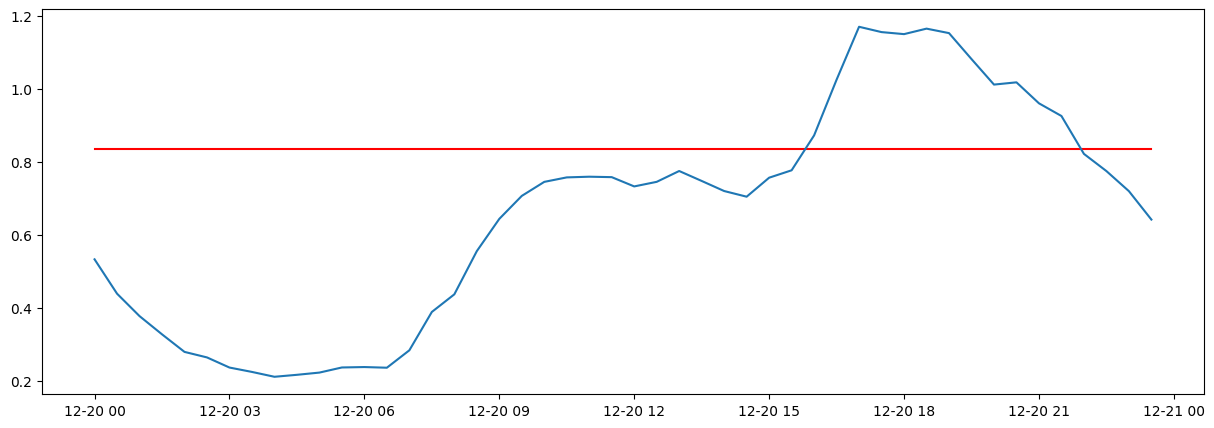

In [290]:
def trace(p):
    plt.figure(figsize=(15,5))
    quantile_75 = dataset_journée(2009,12,p)['mean'].describe()['75%']
    plt.plot(dataset_journée(2009,12,p)['time'].to_list(),[quantile_75 for i in range(len(dataset_journée(2009,12,p)['time'].to_list()))],color='red')
    plt.plot(dataset_journée(2009,12,p)['time'].to_list(), dataset_journée(2009,12,p)['mean'].to_list(), '-')
    plt.show()
trace(20)

# 25 % de la consommation est au dessus de la ligne rouge

### évolution de la consommation pendant le mois de décembre 2009

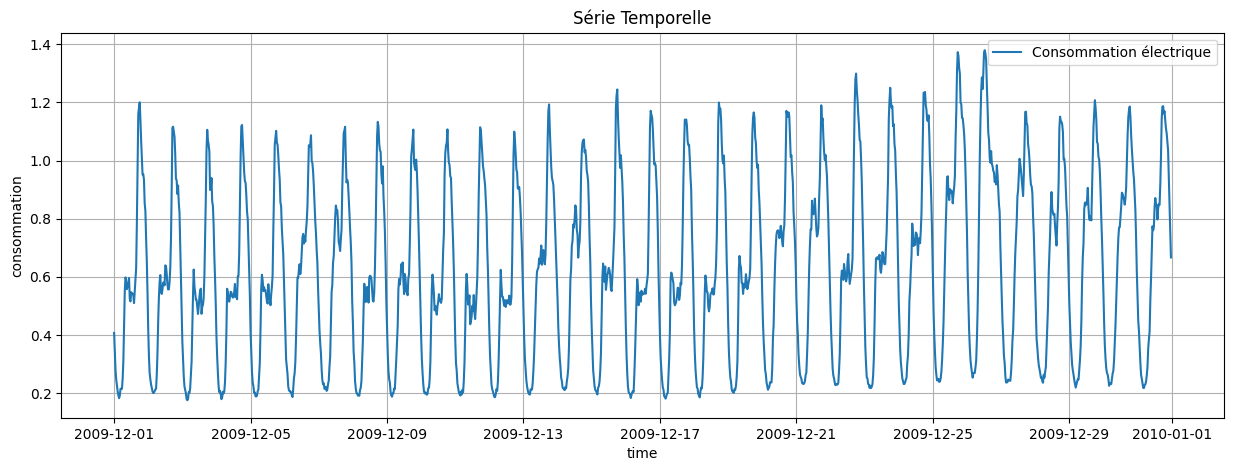

In [137]:
import pandas as pd
import matplotlib.pyplot as plt

# Exemple de données de série temporelle

# Création du DataFrame
df_ = dataset_mois(2009,12)

# Tracé de la série temporelle
plt.figure(figsize=(15, 5))
plt.plot(df_['time'][:], df_['mean'], label='Consommation électrique')
plt.xlabel('time')
plt.ylabel('consommation')
plt.title('Série Temporelle')
plt.legend()
plt.grid(True)
plt.show()




### Test de la stationnarité de la série temporelle des consommation

In [291]:
from statsmodels.tsa.stattools import adfuller
consumption = df['mean']
result = adfuller(consumption)

# Afficher les résultats
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')
# Interprétation des résultats
if result[1] < 0.05:
    print("La série est stationnaire (rejeter l'hypothèse nulle)")
else:
    print("La série n'est pas stationnaire (ne pas rejeter l'hypothèse nulle)")

ADF Statistic: -3.3745017341515093
p-value: 0.01185943241638714
Critical Values:
   1%: -3.4306140494936535
   5%: -2.861656701833481
   10%: -2.5668321169820927
La série est stationnaire (rejeter l'hypothèse nulle)


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Charger vos données
df0 = df_to_train_and_test.copy()

# Filtrer les données jusqu'au 14 décembre 2010 pour l'entraînement
df_train = df0[:'2010-12-14']

# Définir les variables endogènes et exogènes
endog = df_train['mean']
exog = df_train.drop("mean")

# Filtrer les données météorologiques futures pour les prévisions (15 au 31 décembre 2010)
future_weather = df0.drop('mean')['2010-12-15':'2010-12-31']

# Ajuster le modèle SARIMAX
model = SARIMAX(endog, exog=exog, order=(1, 0, 0), seasonal_order=(1, 1, 1, 48))
model_fit = model.fit(disp=False)

# Prédire les valeurs futures
steps = len(future_weather)
forecast = model_fit.forecast(steps=steps, exog=future_weather)

# Créer un DataFrame pour les prévisions
forecast_df = pd.DataFrame({'forecast': forecast}, index=future_weather.index)

# Plot des résultats
plt.figure(figsize=(12, 6))
plt.plot(df0.index, df['mean'], label='Historical Consumption')
plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecasted Consumption', color='red')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Electricity Consumption Forecast')
plt.legend()
plt.grid(True)
plt.show()






## Régression multilinéaire

C:\Users\dell\AppData\Local\Temp\ipykernel_19628\3449457719.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_data['hour'] = future_data.index.hour
C:\Users\dell\AppData\Local\Temp\ipykernel_19628\3449457719.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_data['month'] = future_data.index.month
C:\Users\dell\AppData\Local\Temp\ipykernel_19628\3449457719.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

R^2: 0.6835016345820223
MSE: 0.022105042519576013
RMSE: 0.14867764633453145
MAPE: 27.37%


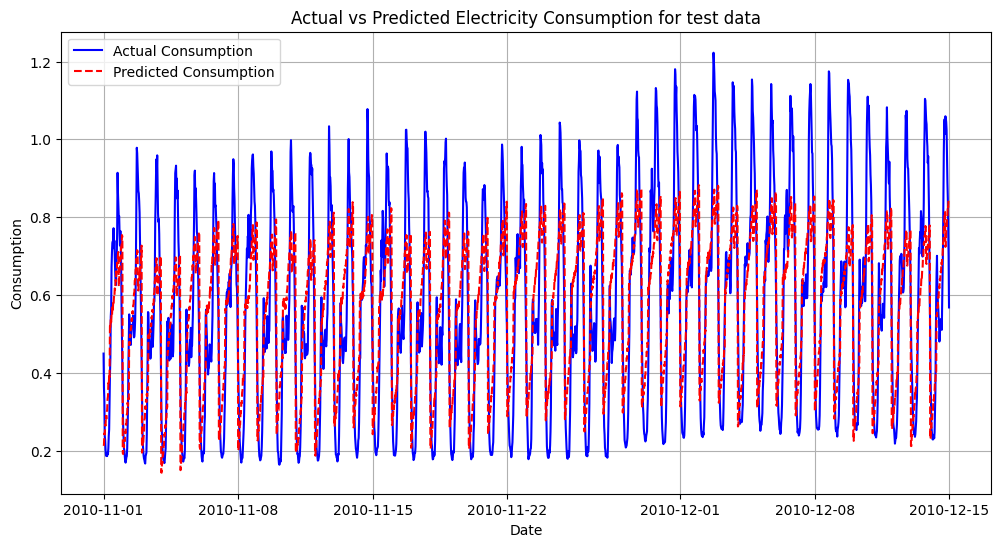

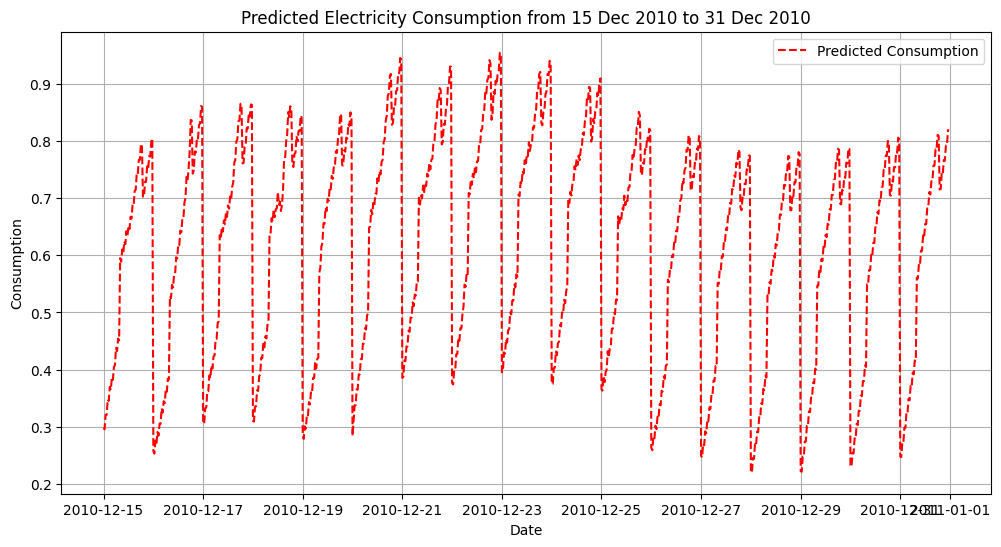

In [295]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Assumons que df_to_train_and_test est votre DataFrame avec les colonnes 'temp', 'humidity', 'season', 'rain', etc.
# et que 'mean' est la variable cible

# Filtrer les données de septembre 2009 à décembre 2010
df3 = df_to_train_and_test['2009-09-01':'2010-12-31'][['temp','rhum','work_time','season','mean']] # choix des paramètres

# Créer un DataFrame contenant les données du 15 au 31 décembre 2010 pour la prédiction
future_data = df3['2010-12-15':'2010-12-31']

# Assurez-vous que l'index est de type datetime
df3.index = pd.to_datetime(df3.index)
future_data.index = pd.to_datetime(future_data.index)

# Ajouter des caractéristiques temporelles
df3['hour'] = df3.index.hour
df3['month'] = df3.index.month
df3['day_of_year'] = df3.index.dayofyear
df3['half_hour'] = df3.index.minute // 30  # Capture les intervalles de 30 minutes

future_data['hour'] = future_data.index.hour
future_data['month'] = future_data.index.month
future_data['day_of_year'] = future_data.index.dayofyear
future_data['half_hour'] = future_data.index.minute // 30  # Capture les intervalles de 30 minutes

# Définir la période de test pour décembre 2009
start_time_test = pd.Timestamp('2010-11-1 00:00:00')
end_time_test = pd.Timestamp('2010-12-14 23:59:59')

# Filtrer les données pour l'entraînement et le test
train_data = df3[df3.index < start_time_test]
test_data = df3[(df3.index >= start_time_test) & (df3.index <= end_time_test)]

# Séparer les caractéristiques et la cible
X_train = train_data.drop(columns=['mean'])
y_train = train_data['mean']
X_test = test_data.drop(columns=['mean'])
y_test = test_data['mean']

# Normaliser les données (optionnel mais recommandé)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
future_data_scaled = scaler.transform(future_data.drop(columns=['mean']))

# Créer et ajuster le modèle de régression
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Faire des prédictions
y_pred = model.predict(X_test_scaled)
future_consumption_pred = model.predict(future_data_scaled)

# Ajouter les prédictions au DataFrame future_data
future_data['predicted_consumption'] = future_consumption_pred

# Ajouter les prédictions au DataFrame test_data pour visualisation
test_data['predicted_consumption'] = y_pred

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'R^2: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape * 100:.2f}%')

# Visualiser les résultats pour décembre 2009
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Actual Consumption', color='blue')
plt.plot(test_data.index, y_pred, label='Predicted Consumption', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Actual vs Predicted Electricity Consumption for test data')
plt.legend()
plt.grid(True)
plt.show()

# Visualiser les résultats pour la période de prédiction (15 au 31 décembre 2010)
plt.figure(figsize=(12, 6))
plt.plot(future_data.index, future_data['predicted_consumption'], label='Predicted Consumption', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Predicted Electricity Consumption from 15 Dec 2010 to 31 Dec 2010')
plt.legend()
plt.grid(True)
plt.show()


## Random forest regressor 

C:\Users\dell\AppData\Local\Temp\ipykernel_19628\1993107058.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['hour'] = df5.index.hour


Taille de X_train: (21072, 6)
Taille de X_test: (1488, 6)
R^2: 0.8395669401874171
MSE: 0.015255337818445864
RMSE: 0.12351250065659695
MAPE: 13.16%


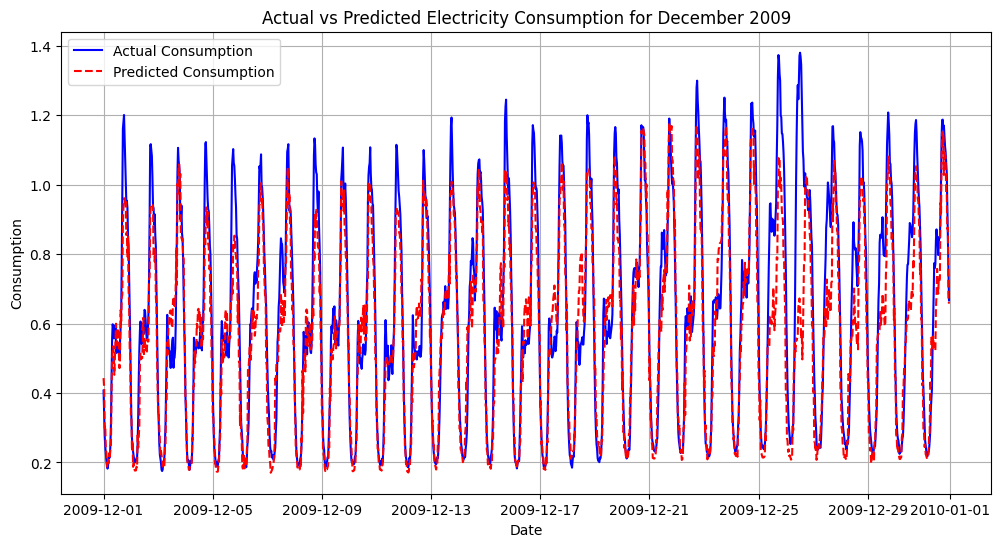

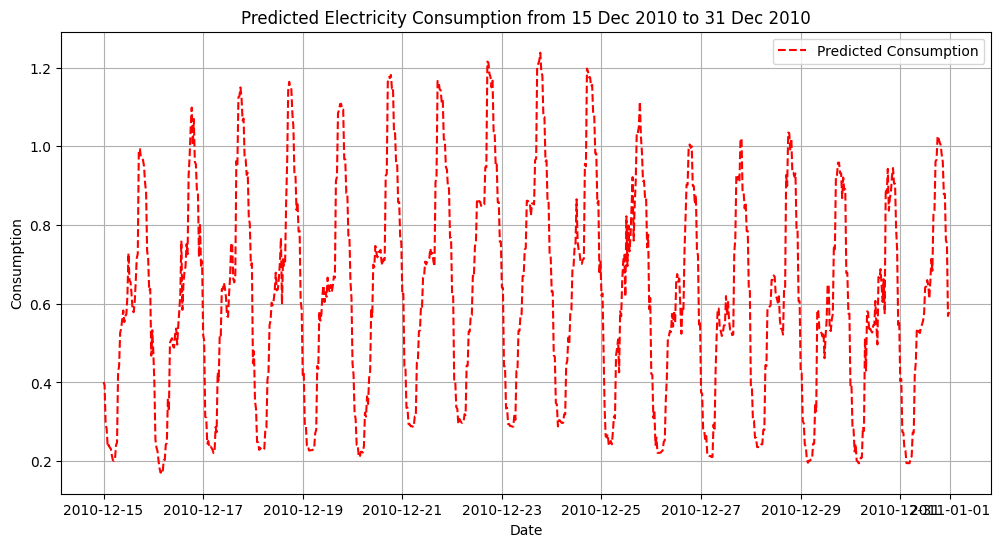

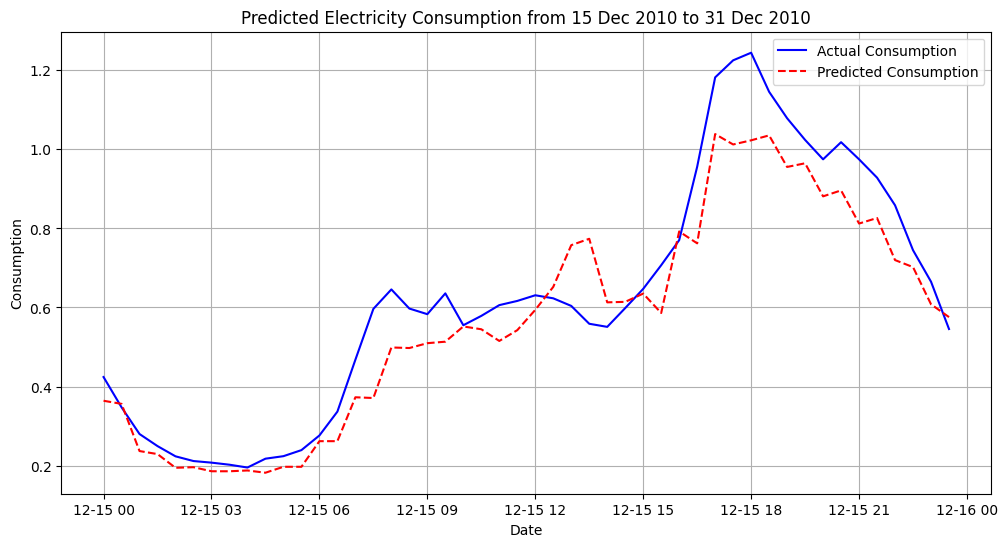

In [296]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Assumons que df_to_train_and_test est votre DataFrame avec les colonnes 'temp', 'humidity', 'season', 'rain', etc.
# et que 'mean' est la variable cible

# Filtrer les données de septembre 2009 à décembre 2010
df5 = df_to_train_and_test['2009-09-01':'2010-12-31']
df5['hour'] = df5.index.hour
df5 = df5[['hour','work_time', 'season','dewpt','temp','rhum','mean']]
df5.index = pd.to_datetime(df5.index)

# Ajouter des caractéristiques temporelles
df5['hour'] = df5.index.hour
#df5['month'] = df5.index.month
#df5['day_of_year'] = df5.index.dayofyear
#df5['half_hour'] = df5.index.minute // 30  # Capture les intervalles de 30 minutes



# Définir la période pour les futures prédictions (15 au 31 décembre 2010)
future_start = pd.Timestamp('2010-12-15 00:00:00')
future_end = pd.Timestamp('2010-12-31 23:59:59')
future_pred_start = pd.Timestamp('2009-12-15 00:00:00')
future_pred_end = pd.Timestamp('2009-12-15 23:59:59')
future_data = df5[(df5.index >= future_start) & (df5.index <= future_end)]
future_pred = df5[(df5.index >= future_pred_start) & (df5.index <= future_pred_end)]
df5 = df5['2009-09-01':'2010-12-14']
# Séparer les caractéristiques et la cible
X = df5.drop(columns=['mean'])
y = df5['mean']


start_time_test = pd.Timestamp('2009-12-01 00:00:00')
end_time_test = pd.Timestamp('2009-12-31 23:59:59')

# Filtrer les données pour l'entraînement et le test
train_data = df5[(df5.index < start_time_test) | (df5.index >= end_time_test)]
test_data = df5[(df5.index >= start_time_test) & (df5.index <= end_time_test)]

# Séparer les caractéristiques et la cible
X_train = train_data.drop(columns=['mean'])
y_train = train_data['mean']
X_test = test_data.drop(columns=['mean'])
y_test = test_data['mean']
# Utiliser train_test_split pour séparer les ensembles d'entraînement et de test

# Vérifier les dimensions des ensembles
print(f'Taille de X_train: {X_train.shape}')
print(f'Taille de X_test: {X_test.shape}')

# Normaliser les données (optionnel mais recommandé)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
future_data_scaled = scaler.transform(future_data.drop(columns=['mean']))
pred_data_scaled = scaler.transform(future_pred.drop(columns=['mean']))




# Créer et ajuster le modèle RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Faire des prédictions avec les deux modèles

y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_combined =  y_pred_rf

y_cons_rf = rf_model.predict(pred_data_scaled)
# Combiner les prédictions (moyenne des prédictions des deux modèles)
y_cons_combined = y_cons_rf

# Faire des prédictions pour les futures données

future_pred_rf = rf_model.predict(future_data_scaled)
future_pred_combined = future_pred_rf

# Ajouter les prédictions au DataFrame future_data
future_data['predicted_consumption'] = future_pred_combined

# Ajouter les prédictions au DataFrame test_data pour visualisation
test_data = X_test.copy()
test_data['actual_consumption'] = y_test
test_data['predicted_consumption'] = y_pred_combined


pred_data = future_pred.drop(columns = "mean").copy()
pred_data['actual_consumption'] = future_pred['mean']
pred_data['predicted_consumption'] = y_cons_combined
# Calculer les métriques de performance
r2 = r2_score(y_test, y_pred_combined)
mse = mean_squared_error(y_test, y_pred_combined)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred_combined)

print(f'R^2: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape * 100:.2f}%')

# Visualiser les résultats pour décembre 2009
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['actual_consumption'], label='Actual Consumption', color='blue')
plt.plot(test_data.index, test_data['predicted_consumption'], label='Predicted Consumption', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Actual vs Predicted Electricity Consumption for December 2009')
plt.legend()
plt.grid(True)
plt.show()

# Visualiser les résultats pour la période de prédiction (15 au 31 décembre 2010)
plt.figure(figsize=(12, 6))

plt.plot(future_data.index, future_data['predicted_consumption'], label='Predicted Consumption', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Predicted Electricity Consumption from 15 Dec 2010 to 31 Dec 2010')
plt.legend()
plt.grid(True)
plt.show()

# visualiser les prévision pendant un seul jour 

plt.figure(figsize=(12, 6))
plt.plot(pred_data.index, pred_data['actual_consumption'], label='Actual Consumption', color='blue')
plt.plot(pred_data.index, pred_data['predicted_consumption'], label='Predicted Consumption', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Predicted Electricity Consumption from 15 Dec 2010 to 31 Dec 2010')
plt.legend()
plt.grid(True)
plt.show()


## Réseau de neuronnes LSTM 

Index(['ind', 'rain', 'ind.1', 'ind.2', 'wetb', 'dewpt', 'vappr', 'rhum',
       'msl', 'ind.3', 'wdsp', 'ind.4', 'wddir', 'ww', 'w', 'sun', 'vis',
       'clht', 'clamt', 'weekend', 'season', 'work_time', 'mean', 'temp',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6'],
      dtype='object')
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 1, 50)             22800     
               

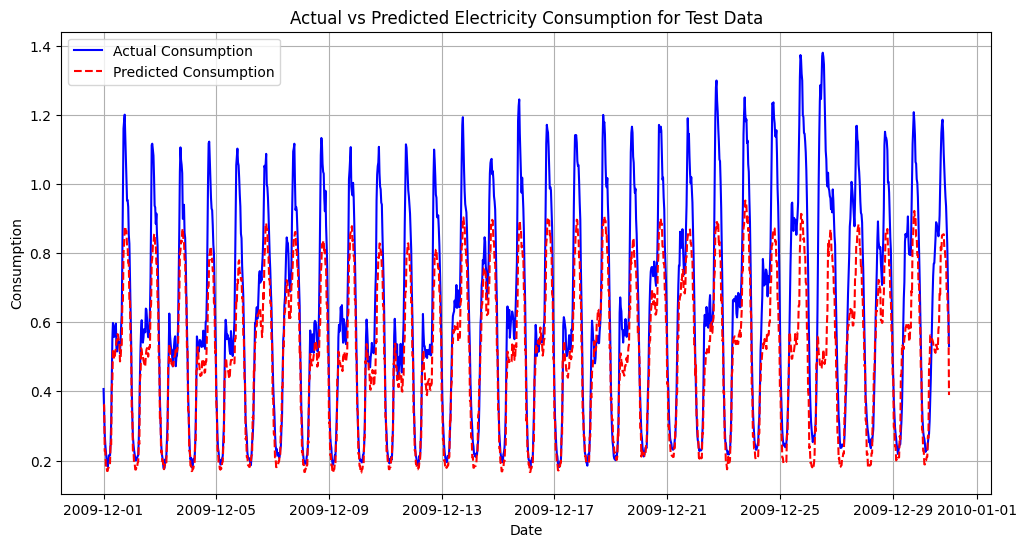

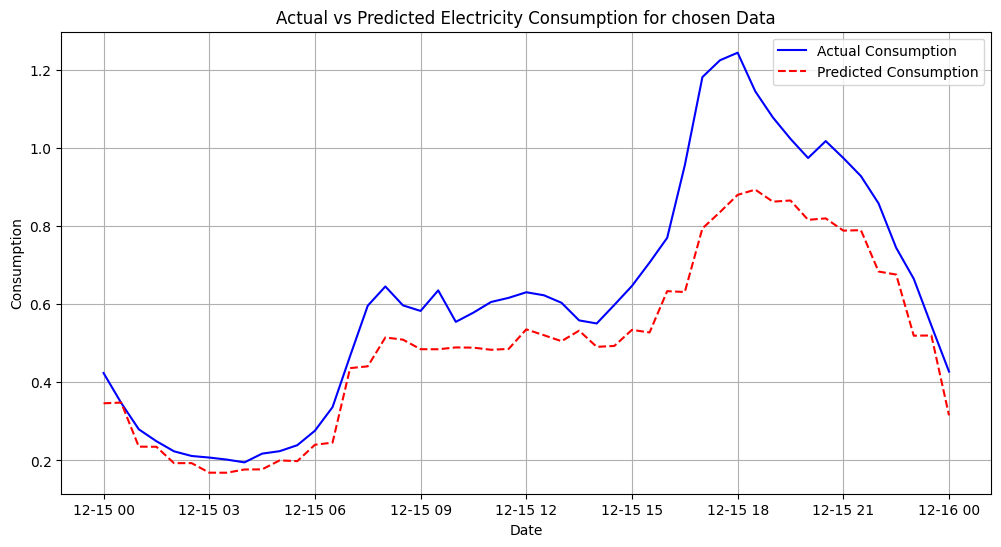

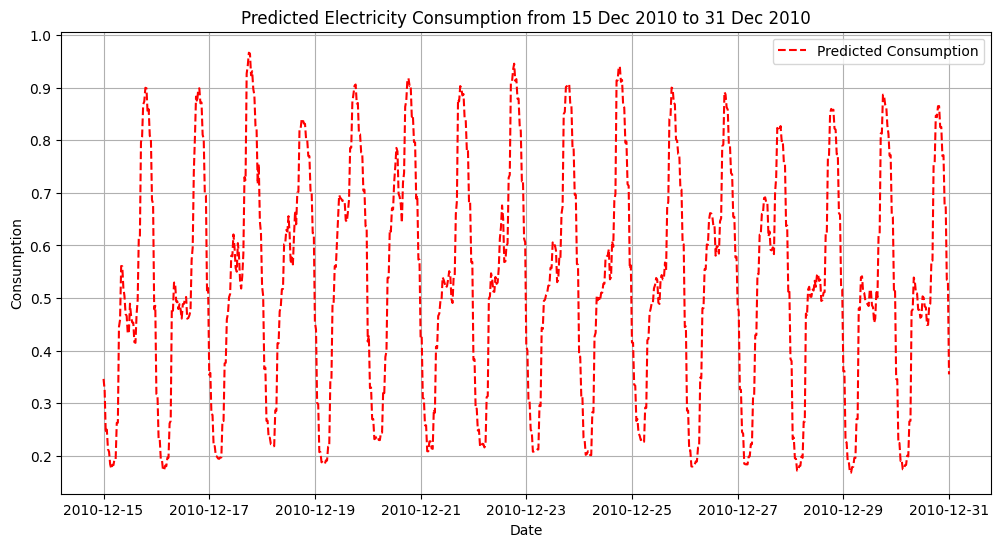

In [253]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Charger les données et filtrer de septembre 2009 à décembre 2010
df6 = df_to_train_and_test['2009-09-01':'2010-12-31'].copy()

df6['hour'] = df6.index.hour
df6['month'] = df6.index.month
df6['day_of_week'] = df6.index.weekday

df6 = pd.get_dummies(df6, columns=['hour', 'month', 'day_of_week'], drop_first=True)

df6.drop(columns=['ind', 'rain', 'ind.1', 'ind.2', 'wetb', 'vappr',
       'msl', 'ind.3', 'wdsp', 'ind.4', 'wddir', 'ww', 'w', 'sun', 'vis',
       'clht', 'clamt', 'weekend', 'mean'])
print(df6.columns)
df6.index = pd.to_datetime(df6.index)

# Ajouter des caractéristiques temporelles
#df6['hour'] = df6.index.hour


# Capture les intervalles de 30 minutes

# Définir les périodes d'entraînement, de validation et de test
train_start_1 = pd.Timestamp('2009-07-15')
train_end_1 = pd.Timestamp('2009-11-30')
train_start_2 = pd.Timestamp('2010-01-01')
train_end_2 = pd.Timestamp('2010-11-15')
val_start = pd.Timestamp('2010-11-16')
val_end = pd.Timestamp('2010-12-14')
test_start = pd.Timestamp('2009-12-01')
test_end = pd.Timestamp('2009-12-31')
pred_start = pd.Timestamp('2010-12-15')
pred_end = pd.Timestamp('2010-12-31')
choice_start = pd.Timestamp('2009-12-15')
choice_end = pd.Timestamp('2009-12-16')


# Créer les ensembles d'entraînement, de validation et de test
train_data = df6[((df6.index >= train_start_1) & (df6.index <= train_end_1) )| ((df6.index >= train_start_2) & (df6.index <= train_end_2) )]
val_data = df6[(df6.index >= val_start) & (df6.index <= val_end)]
test_data = df6[(df6.index >= test_start) & (df6.index <= test_end)]
future_data = df6[(df6.index >= pred_start) & (df6.index <= pred_end)].drop(columns=['mean'])
pred_data=df6[(df6.index >= choice_start) & (df6.index <= choice_end)]
# Ajouter des variables indicatrices pour les heures, mois et jours de la semaine

df6 = df6[:'2010-12-15']

# Séparer les caractéristiques (X) et la cible (y) pour chaque ensemble
X_train = train_data.drop(columns=['mean'])
y_train = train_data['mean']
X_val = val_data.drop(columns=['mean'])
y_val = val_data['mean']
X_test = test_data.drop(columns=['mean'])
y_test = test_data['mean']
X_choice = pred_data.drop(columns=['mean'])
y_choice = pred_data['mean']



# Normaliser les données
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)
future_data_scaled = scaler_X.transform(future_data)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))
X_choice_scaled = scaler_X.transform(X_choice)
y_choice_scaled = scaler_y.transform(y_choice.values.reshape(-1, 1))
# Reshape les données pour LSTM [samples, timesteps, features]
timesteps = 1
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], timesteps, X_train_scaled.shape[1]))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], timesteps, X_val_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1]))
future_data_scaled = future_data_scaled.reshape((future_data_scaled.shape[0], timesteps, future_data_scaled.shape[1]))
X_choice_scaled = X_choice_scaled.reshape((X_choice_scaled.shape[0], timesteps, X_choice_scaled.shape[1]))

# Construire le modèle LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timesteps, X_train_scaled.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compiler le modèle avec l'optimiseur Adam et la fonction de perte MSE
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Entraîner le modèle
history = model.fit(X_train_scaled, y_train_scaled, epochs=25, batch_size=16, validation_data=(X_val_scaled, y_val_scaled), verbose=2, shuffle=False)

# Faire des prédictions sur les ensembles de test et futures
y_pred_scaled = model.predict(X_test_scaled)
future_pred_scaled = model.predict(future_data_scaled)

choice_pred = model.predict(X_choice_scaled)
# Inverser la normalisation des prédictions et des vraies valeurs pour revenir à l'échelle originale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)
future_pred = scaler_y.inverse_transform(future_pred_scaled)
y_choice_pred = scaler_y.inverse_transform(choice_pred)

# Ajouter les prédictions au DataFrame future_data
future_data['predicted_consumption'] = future_pred

# Ajouter les prédictions au DataFrame test_data pour visualisation
test_data['predicted_consumption'] = y_pred
test_data['actual_consumption'] = y_test

pred_data['predicted_consumption'] = y_choice_pred
pred_data['actual_consumption'] = y_choice
# Calculer les métriques de performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Afficher les métriques de performance
print(f'R^2: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape * 100:.2f}%')

# Visualiser les résultats pour l'ensemble de test
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['actual_consumption'], label='Actual Consumption', color='blue')
plt.plot(test_data.index, test_data['predicted_consumption'], label='Predicted Consumption', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Actual vs Predicted Electricity Consumption for Test Data')
plt.legend()
plt.grid(True)
plt.show()

# Visualiser les résultats pour l'ensemble choisi
plt.figure(figsize=(12, 6))
plt.plot(pred_data.index, pred_data['actual_consumption'], label='Actual Consumption', color='blue')
plt.plot(pred_data.index, pred_data['predicted_consumption'], label='Predicted Consumption', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Actual vs Predicted Electricity Consumption for chosen Data')
plt.legend()
plt.grid(True)
plt.show()

# Visualiser les résultats pour la période de prédiction (15 au 31 décembre 2010)
plt.figure(figsize=(12, 6))
plt.plot(future_data.index, future_data['predicted_consumption'], label='Predicted Consumption', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Predicted Electricity Consumption from 15 Dec 2010 to 31 Dec 2010')
plt.legend()
plt.grid(True)
plt.show()
